# Modeling using Time-Series 
### (Additional analysis outside of initial project scope)

---


While the aim for this project was to build a regression and relationships of the individual regions, since the data occurs over time, it was worthwhile to at the very least to explore Time-Series analysis for the sake of completeness as well as exploration. It was a goal to examine these Time-Series model to determine if it was worthwhile to use rather than Regression. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling-using-Time-Series" data-toc-modified-id="Modeling-using-Time-Series-1">Modeling using Time-Series</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#(Additional-analysis-outside-of-initial-project-scope)" data-toc-modified-id="(Additional-analysis-outside-of-initial-project-scope)-1.0.1">(Additional analysis outside of initial project scope)</a></span></li></ul></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1">Imports</a></span></li><li><span><a href="#Permian-Region-Selected-Only-for-Time-Series" data-toc-modified-id="Permian-Region-Selected-Only-for-Time-Series-1.2">Permian Region Selected Only for Time-Series</a></span></li><li><span><a href="#SARIMAX-Model" data-toc-modified-id="SARIMAX-Model-1.3">SARIMAX Model</a></span><ul class="toc-item"><li><span><a href="#Model-Instantiation-and-Fit" data-toc-modified-id="Model-Instantiation-and-Fit-1.3.1">Model Instantiation and Fit</a></span></li><li><span><a href="#Plot-Test-vs.-Predictions" data-toc-modified-id="Plot-Test-vs.-Predictions-1.3.2">Plot Test vs. Predictions</a></span></li></ul></li><li><span><a href="#Facebook-Prophet-Time-Series" data-toc-modified-id="Facebook-Prophet-Time-Series-1.4">Facebook Prophet Time-Series</a></span><ul class="toc-item"><li><span><a href="#Model-Instantiation-and-Fit" data-toc-modified-id="Model-Instantiation-and-Fit-1.4.1">Model Instantiation and Fit</a></span></li><li><span><a href="#Prophet-Prediction-Plot" data-toc-modified-id="Prophet-Prediction-Plot-1.4.2">Prophet Prediction Plot</a></span></li><li><span><a href="#Prophet-Components-Plot" data-toc-modified-id="Prophet-Components-Plot-1.4.3">Prophet Components Plot</a></span></li><li><span><a href="#Prophet-Changepoints-Plot" data-toc-modified-id="Prophet-Changepoints-Plot-1.4.4">Prophet Changepoints Plot</a></span></li></ul></li></ul></li><li><span><a href="#Next-Notebook" data-toc-modified-id="Next-Notebook-2">Next Notebook</a></span></li></ul></div>

## Imports

In [124]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import warnings
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.ticker as mtick


warnings.filterwarnings("ignore")

In [126]:
from tools.tools import read_json, get_current_time

In [127]:
plt.style.use('ggplot')

In [128]:
config = read_json('../capstone/config.json')

current_date = get_current_time('yyyymmdd')

wd = f"{config['workspace_directory']}/data"

In [129]:
basin_colors_hex = {  # manually defined dictionary of EIA basin-level standardized colors 
    "Anadarko Region":    "#2BA2CF", 
    "Appalachia Region":  "#769F5D",
    "Bakken Region":      "#F6C432", 
    "Eagle Ford Region":  "#48366B", 
    "Haynesville Region": "#807B8F",
    "Niobrara Region":    "#9D3341",
    "Permian Region":     "#6F4B27",
}

In [130]:
df = pd.read_csv(f"{wd}/processing/basin_int_viirs_for_modeling.csv")

## Permian Region Selected Only for Time-Series

![basins](https://www.eia.gov/petroleum/drilling/images/dpmapv4l-wtitle_sm2.png)
[_<center>EIA U.S. Basin Regions</center>_](https://www.eia.gov/petroleum/drilling)

In [131]:
df = df[df['region'] == 'Permian Region']

In [132]:
df['year_month'] = pd.to_datetime(df['year_month']).dt.to_period('M')
df.set_index('year_month', inplace=True)
df.sort_index(inplace=True)  # sort by datetime just to be safe

In [133]:
df.shape

(97, 83)

In [134]:
df.head(3)

,region,latest_day_in_month,obs_day_cnt_avg,obs_day_cnt_med,obs_day_cnt_sum,obs_day_cnt_min,obs_day_cnt_max,qf_fit_day_avg_avg,qf_fit_day_avg_med,qf_fit_day_avg_sum,...,obs_day_cnt_avg_over_pct_month_completed,obs_day_cnt_med_over_pct_month_completed,obs_day_cnt_sum_over_pct_month_completed,obs_day_cnt_min_over_pct_month_completed,obs_day_cnt_max_over_pct_month_completed,obs_day_cnt_avg_per_squaremeters_over_pct_month_completed,obs_day_cnt_med_per_squaremeters_over_pct_month_completed,obs_day_cnt_sum_per_squaremeters_over_pct_month_completed,obs_day_cnt_min_per_squaremeters_over_pct_month_completed,obs_day_cnt_max_per_squaremeters_over_pct_month_completed
year_month,,,,,,,,,,,,,,,,,,,,,
2012-03,Permian Region,2012-03-31,50.964286,48.0,1427,12,112,1.807258,1.488728,50.603236,...,50.964286,48.0,1427.0,12.0,112.0,2.405388e-10,2.265481e-10,6.735085e-09,5.663702e-11,5.286122e-10
2012-04,Permian Region,2012-04-30,54.833333,53.5,1645,7,144,2.090061,1.270513,62.701818,...,54.833333,53.5,1645.0,7.0,144.0,2.587997e-10,2.525067e-10,7.763991e-09,3.303826e-11,6.796442e-10
2012-05,Permian Region,2012-05-31,80.689655,76.0,2340,8,202,3.002493,2.513158,87.072283,...,80.689655,76.0,2340.0,8.0,202.0,3.808351e-10,3.587011e-10,1.104422e-08,3.775801e-11,9.533898e-10


In [135]:
X = df.drop(columns=[
    'oil_bbl_d_total_production',
    'latest_day_in_month',
    'last_day_of_month',
    'first_day_of_month',
    # 'year_month',
])

X = pd.get_dummies(X)

y = df['oil_bbl_d_total_production']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.10, 
    shuffle=False,
)

In [136]:
X_train.tail(3)                       

,obs_day_cnt_avg,obs_day_cnt_med,obs_day_cnt_sum,obs_day_cnt_min,obs_day_cnt_max,qf_fit_day_avg_avg,qf_fit_day_avg_med,qf_fit_day_avg_sum,qf_fit_day_avg_min,qf_fit_day_avg_max,...,obs_day_cnt_med_over_pct_month_completed,obs_day_cnt_sum_over_pct_month_completed,obs_day_cnt_min_over_pct_month_completed,obs_day_cnt_max_over_pct_month_completed,obs_day_cnt_avg_per_squaremeters_over_pct_month_completed,obs_day_cnt_med_per_squaremeters_over_pct_month_completed,obs_day_cnt_sum_per_squaremeters_over_pct_month_completed,obs_day_cnt_min_per_squaremeters_over_pct_month_completed,obs_day_cnt_max_per_squaremeters_over_pct_month_completed,region_Permian Region
year_month,,,,,,,,,,,,,,,,,,,,,
2019-03,290.933333,315.5,8728,3,561,4.126076,3.829408,123.782269,0.590909,8.573643,...,315.5,8728.0,3.0,561.0,1.373133e-09,1.489082e-09,4.119399e-08,1.415925e-11,2.647781e-09,1
2019-04,328.200000,360.0,9846,10,651,4.746977,4.483562,142.409303,2.241379,8.324117,...,360.0,9846.0,10.0,651.0,1.549022e-09,1.699111e-09,4.647067e-08,4.719751e-11,3.072558e-09,1
2019-05,303.354839,321.0,9404,58,556,3.787968,3.532374,117.427007,1.903226,7.204918,...,321.0,9404.0,58.0,556.0,1.431759e-09,1.515040e-09,4.438454e-08,2.737456e-10,2.624182e-09,1


In [137]:
 X_test.tail(45)

,obs_day_cnt_avg,obs_day_cnt_med,obs_day_cnt_sum,obs_day_cnt_min,obs_day_cnt_max,qf_fit_day_avg_avg,qf_fit_day_avg_med,qf_fit_day_avg_sum,qf_fit_day_avg_min,qf_fit_day_avg_max,...,obs_day_cnt_med_over_pct_month_completed,obs_day_cnt_sum_over_pct_month_completed,obs_day_cnt_min_over_pct_month_completed,obs_day_cnt_max_over_pct_month_completed,obs_day_cnt_avg_per_squaremeters_over_pct_month_completed,obs_day_cnt_med_per_squaremeters_over_pct_month_completed,obs_day_cnt_sum_per_squaremeters_over_pct_month_completed,obs_day_cnt_min_per_squaremeters_over_pct_month_completed,obs_day_cnt_max_per_squaremeters_over_pct_month_completed,region_Permian Region
year_month,,,,,,,,,,,,,,,,,,,,,
2019-06,336.833333,359.5,10105,11,636,4.222918,4.304975,126.687530,0.454545,6.644068,...,359.500000,10105.000000,11.000000,636.000000,1.589770e-09,1.696751e-09,4.769309e-08,5.191727e-11,3.001762e-09,1
2019-07,372.129032,365.0,11536,95,767,4.003925,3.629630,124.121665,1.463415,7.811138,...,365.000000,11536.000000,95.000000,767.000000,1.756357e-09,1.722709e-09,5.444705e-08,4.483764e-10,3.620049e-09,1
2019-08,396.548387,407.0,12293,80,722,4.655401,4.465882,144.317437,1.855305,7.857671,...,407.000000,12293.000000,80.000000,722.000000,1.871610e-09,1.920939e-09,5.801990e-08,3.775801e-10,3.407661e-09,1
2019-09,341.310345,332.0,9898,7,615,4.092949,3.955224,118.695528,1.929907,7.067496,...,332.000000,9898.000000,7.000000,615.000000,1.610900e-09,1.566957e-09,4.671610e-08,3.303826e-11,2.902647e-09,1
2019-10,327.566667,329.0,9827,19,709,4.313043,4.541641,129.391291,0.421053,6.941463,...,340.344828,10165.862069,19.655172,733.448276,1.599345e-09,1.606343e-09,4.798034e-08,9.276753e-11,3.461694e-09,1
2019-11,331.607143,326.5,9285,2,659,3.951521,4.254208,110.642586,0.500000,6.508929,...,326.500000,9285.000000,2.000000,659.000000,1.565103e-09,1.540999e-09,4.382289e-08,9.439503e-12,3.110316e-09,1
2019-12,324.548387,346.0,10061,8,590,3.912373,3.563679,121.283549,2.040984,6.451282,...,346.000000,10061.000000,8.000000,590.000000,1.531788e-09,1.633034e-09,4.748542e-08,3.775801e-11,2.784653e-09,1
2020-01,309.413793,322.0,8973,6,627,3.997350,4.188202,115.923159,0.666667,5.734483,...,322.000000,8973.000000,6.000000,627.000000,1.460356e-09,1.519760e-09,4.235033e-08,2.831851e-11,2.959284e-09,1
2020-02,309.333333,341.0,8352,7,802,5.008425,5.078717,135.227472,0.521739,9.978803,...,341.000000,8352.000000,7.000000,802.000000,1.459976e-09,1.609435e-09,3.941936e-08,3.303826e-11,3.785241e-09,1


## SARIMAX Model
### Model Instantiation and Fit


In [138]:
sarimax = SARIMAX(
    endog = y_train,
    order = (0, 2, 1),              # (p, d, q)
    seasonal_order = (1, 0, 0, 12), # (P, D, Q, S)
    exog = X_train[[
        'obs_day_cnt_sum_over_pct_month_completed',
        'obs_day_cnt_avg',
        'qf_fit_day_avg_avg',
    ]]
) 

# Fit SARIMAX model.
model = sarimax.fit()

In [139]:
# Display our summary!
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:         oil_bbl_d_total_production   No. Observations:                   87
Model:             SARIMAX(0, 2, 1)x(1, 0, 0, 12)   Log Likelihood               -1049.440
Date:                            Thu, 12 Mar 2020   AIC                           2110.880
Time:                                    09:37:53   BIC                           2125.536
Sample:                                03-31-2012   HQIC                          2116.775
                                     - 05-31-2019                                         
Covariance Type:                              opg                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
obs_day_cnt_sum_over_pct_month_completed   -28.0492   

In [140]:
# Generate predictions based on test set.
preds = model.predict(
    start=datetime(2019, 6, 1),
    end=datetime(2020, 3, 1),
    exog=X_test[[
        'obs_day_cnt_sum_over_pct_month_completed',
        'obs_day_cnt_avg',
        'qf_fit_day_avg_avg',
    ]]
)


In [141]:
r2_score(y_test, preds)  # interpreted as not good. 

-1.0785070621160506

In [142]:
# Calculate RMSE.
mean_squared_error(y_test, preds) ** 0.5

271456.60007317486

In [143]:
preds.index = preds.index.to_timestamp()  # set indexes for plotting
y_test.index = y_test.index.to_timestamp()
y_train.index = y_train.index.to_timestamp()
y.index = y.index.to_timestamp()

### Plot Test vs. Predictions

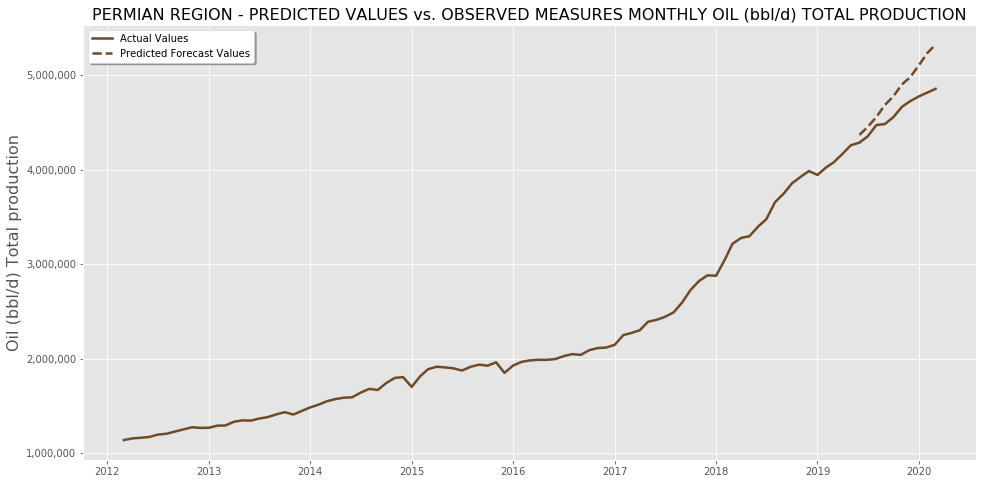

In [144]:
# Plot data.
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

plt.plot(y, color=basin_colors_hex['Permian Region'], label='Actual Values', linewidth=2.5)
#plt.plot(y, color=basin_colors_hex['Permian Region'], linewidth=4)

plt.plot(preds, color=basin_colors_hex['Permian Region'], label='Predicted Forecast Values', linestyle='dashed', linewidth=2.5)
plt.legend(
    loc=2,
    shadow=True, 
    facecolor='white',
)
plt.title(label = 'PERMIAN REGION - PREDICTED VALUES vs. OBSERVED MEASURES MONTHLY OIL (bbl/d) TOTAL PRODUCTION', fontsize=16)

fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

ax.set_ylabel('Oil (bbl/d) Total production', fontsize=16)

plt.savefig(f'../images/sarimax_predicted_vs_observed_entire_time_period.png', dpi=300)
plt.show();

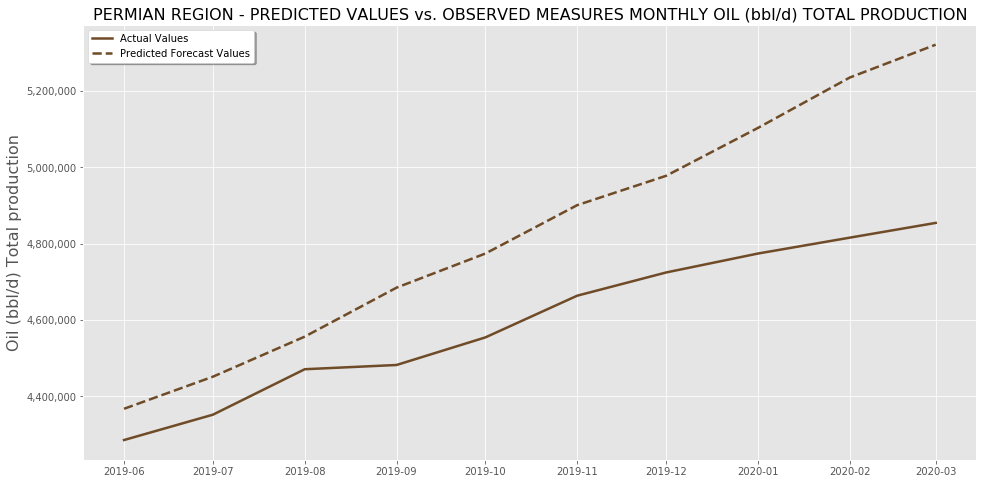

In [145]:
# Plot data.
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

plt.plot(y_test, color=basin_colors_hex['Permian Region'], label='Actual Values', linewidth=2.5)
plt.plot(preds, color=basin_colors_hex['Permian Region'], label='Predicted Forecast Values', linestyle='dashed', linewidth=2.5)
plt.legend(
    loc=2,
    shadow=True, 
    facecolor='white',
)
plt.title(label = 'PERMIAN REGION - PREDICTED VALUES vs. OBSERVED MEASURES MONTHLY OIL (bbl/d) TOTAL PRODUCTION', fontsize=16)

fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

ax.set_ylabel('Oil (bbl/d) Total production', fontsize=16)

plt.savefig(f'../images/sarimax_predicted_vs_observed.png', dpi=300)
plt.show();

## Facebook Prophet Time-Series

In [146]:
df_prophet = df.reset_index()[[
    'year_month', 
    'oil_bbl_d_total_production', 
    'obs_day_cnt_sum_over_pct_month_completed',
    'obs_day_cnt_avg',
]]

df_prophet['year_month'] = df_prophet['year_month'].dt.to_timestamp()
df_prophet.columns = ['ds', 'y', 'obs_day_cnt_sum_over_pct_month_completed', 'obs_day_cnt_avg']
# prophet reques specific column names
df_prophet.head()

,ds,y,obs_day_cnt_sum_over_pct_month_completed,obs_day_cnt_avg
0,2012-03-01,1137072.22,1427.0,50.964286
1,2012-04-01,1154349.66,1645.0,54.833333
2,2012-05-01,1161062.06,2340.0,80.689655
3,2012-06-01,1169848.23,2748.0,94.758621
4,2012-07-01,1194699.38,2022.0,65.225806


### Model Instantiation and Fit

In [147]:
# from fb prophet tutorial
prophet_model = Prophet(weekly_seasonality=False, daily_seasonality=False) # instantiate a new Prophet model
prophet_model.fit(df_prophet); # fit the model to the data

In [148]:
prophet_future = prophet_model.make_future_dataframe(periods=24, freq='MS') # make a df for the future

In [149]:
# Use your model to 'populate' the future df with predictions
prophet_forecast = prophet_model.predict(prophet_future)
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2012-03-01,1.122781e+06,1.084082e+06,1.159746e+06
1,2012-04-01,1.151767e+06,1.116076e+06,1.189377e+06
2,2012-05-01,1.163221e+06,1.126004e+06,1.201517e+06
3,2012-06-01,1.170608e+06,1.133866e+06,1.211011e+06
4,2012-07-01,1.197065e+06,1.163464e+06,1.234268e+06
...,...,...,...,...
116,2021-11-01,6.314529e+06,6.082690e+06,6.564148e+06
117,2021-12-01,6.360065e+06,6.110504e+06,6.630735e+06
118,2022-01-01,6.390894e+06,6.118253e+06,6.680776e+06
119,2022-02-01,6.496281e+06,6.205951e+06,6.805391e+06


In [150]:
preds_historical = prophet_forecast[['ds', 'yhat']].head(prophet_forecast.shape[0] - 24)  # minus periods
preds_historical.head()

,ds,yhat
0,2012-03-01,1.122781e+06
1,2012-04-01,1.151767e+06
2,2012-05-01,1.163221e+06
3,2012-06-01,1.170608e+06
4,2012-07-01,1.197065e+06


In [151]:
mean_squared_error(y, preds_historical['yhat']) ** 0.5

29499.589638913185

### Prophet Prediction Plot

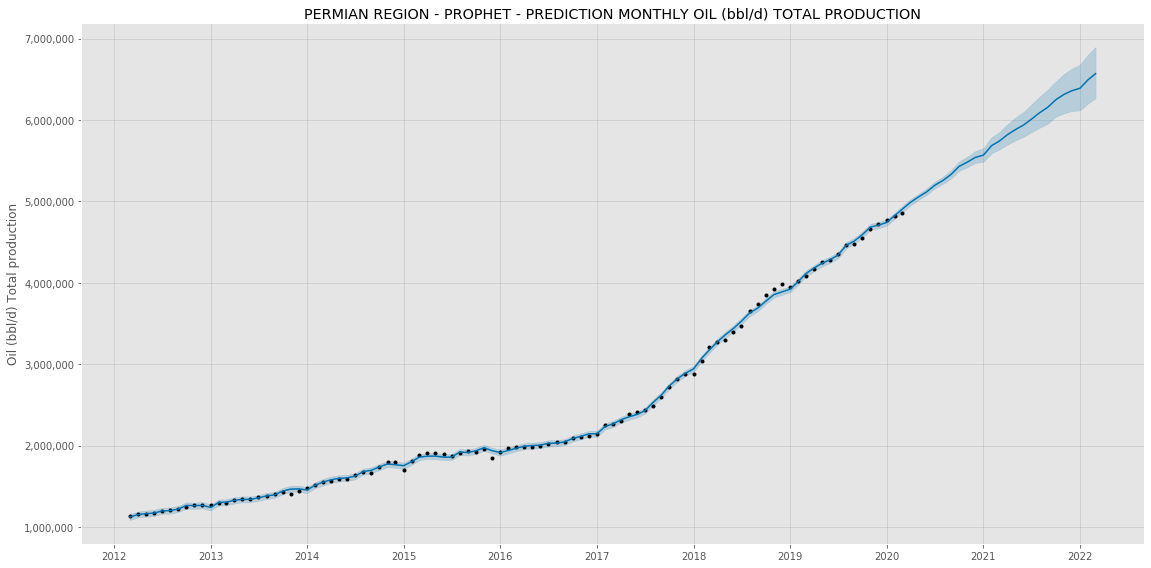

In [152]:
fig = prophet_model.plot(prophet_forecast, figsize=(16, 8))
plt.title('PERMIAN REGION - PROPHET - PREDICTION MONTHLY OIL (bbl/d) TOTAL PRODUCTION')

ax = fig.gca()
ax.set_ylabel('Oil (bbl/d) Total production')

fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

ax.set_xlabel('')

plt.savefig(f'../images/prophet_predictions.png', dpi=300)
plt.show();

### Prophet Components Plot

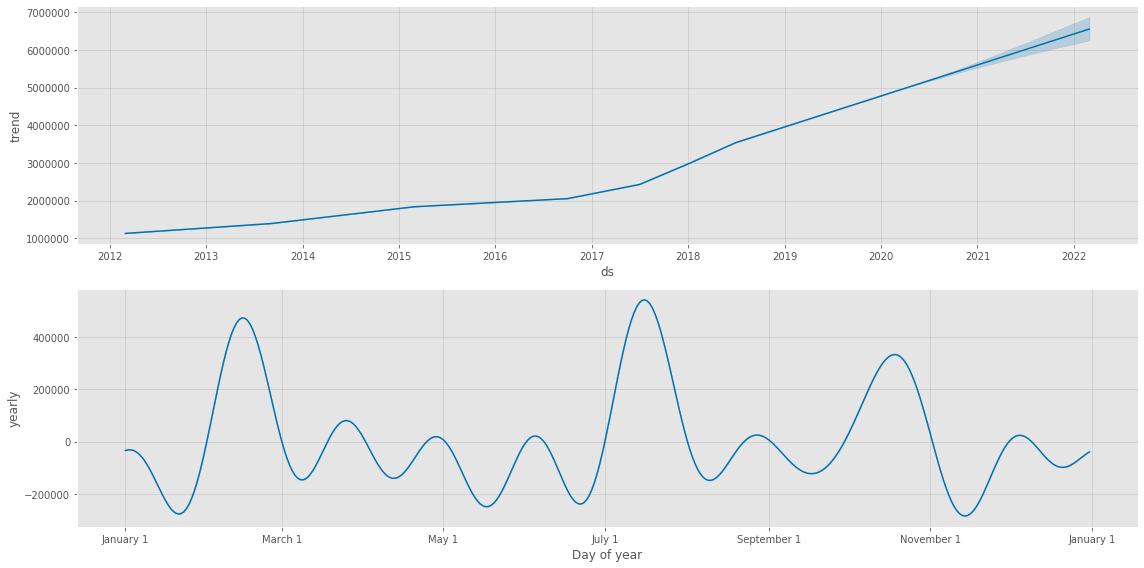

In [153]:
fig_c = prophet_model.plot_components(prophet_forecast, figsize=(16, 8))

plt.savefig(f'../images/prophet_components.png', dpi=300)
plt.show();

### Prophet Changepoints Plot

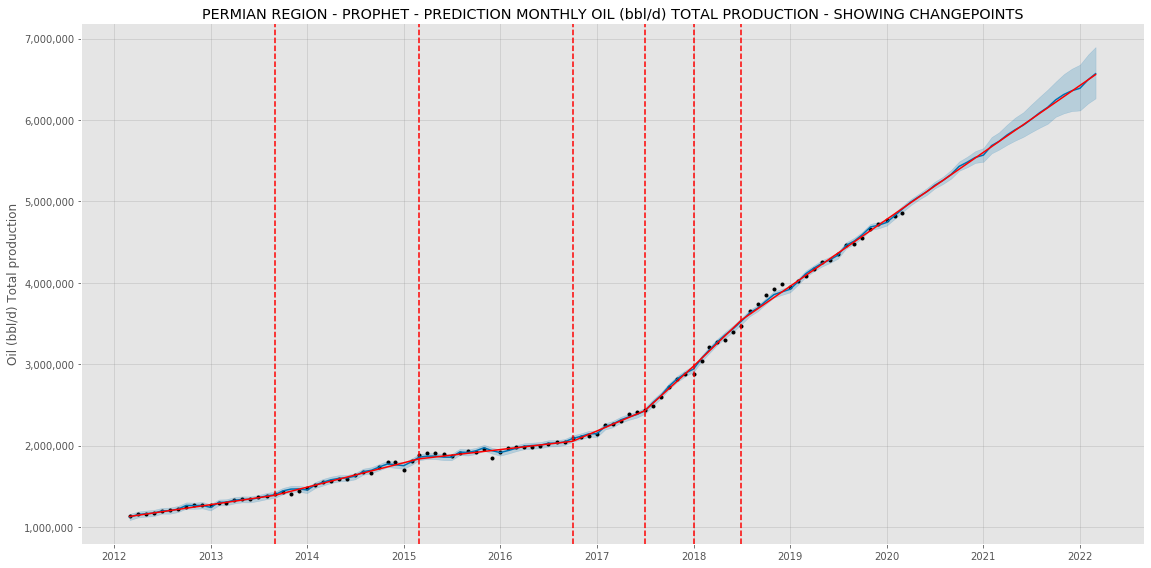

In [154]:
fig = prophet_model.plot(prophet_forecast, figsize=(16, 8))
add_changepoints_to_plot(fig.gca(), prophet_model, prophet_forecast)  # automatic changepoints

plt.title('PERMIAN REGION - PROPHET - PREDICTION MONTHLY OIL (bbl/d) TOTAL PRODUCTION - SHOWING CHANGEPOINTS')

ax = fig.gca()
ax.set_ylabel('Oil (bbl/d) Total production')

fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

ax.set_xlabel('')

plt.savefig(f'../images/prophet_changepoints.png', dpi=300)
plt.show();

# Next Notebook

[Results and Conclusion](https://git.generalassemb.ly/danielmartinsheehan/capstone/blob/master/notebooks/07_results_and_conclusion.ipynb)